## Basic Imports

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import os

import matplotlib.pyplot as plt

from sklearn.preprocessing import Imputer

%matplotlib inline

# to make this notebook's output stable across runs
np.random.seed(42)

## Loading Data

In [2]:
DATA_PATH = os.path.join("../data/")

def load_churn_data(path=DATA_PATH, train=True):
    if train:
        csv_path = os.path.join(path, "churn_train.csv")
    else:
        csv_path = os.path.join(path, "churn_test.csv")
    return pd.read_csv(csv_path)

In [3]:
#load dataframe
churn_orig = load_churn_data()
#make a copy of the ogiginal
churn = churn_orig.copy()


## Basic Data Exploration

**It looks like our training data has the following shape**:
- 40,000 data points
- each data point has 12 features

**Feature Types**:
- 1 boolean
- 1 integer
- 4 objects
- 6 floats


**Features With Missing Values**:
- 'avg_rating_by_driver'
- 'avg_rating_of_driver'
- 'phone' 

**Categorical Features**:
- 'city'
    - Winterfell
    - Astapor
    - King's Landing
    
- 'phone'
    - iPhone
    - Android

In [4]:
churn.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,6.94,5.0,5.0,1.00,Astapor,2014-05-03,Android,2014-01-12,0.0,0,False,100.0
1,8.06,5.0,5.0,1.00,Astapor,2014-01-26,Android,2014-01-25,0.0,2,True,0.0
2,21.50,4.0,NaN,1.00,Winterfell,2014-05-21,iPhone,2014-01-02,0.0,1,True,100.0
3,9.46,5.0,NaN,2.75,Winterfell,2014-01-10,Android,2014-01-09,100.0,1,False,100.0
4,13.77,5.0,NaN,1.00,Winterfell,2014-05-13,iPhone,2014-01-31,0.0,0,False,100.0


In [5]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 12 columns):
avg_dist                  40000 non-null float64
avg_rating_by_driver      39838 non-null float64
avg_rating_of_driver      33472 non-null float64
avg_surge                 40000 non-null float64
city                      40000 non-null object
last_trip_date            40000 non-null object
phone                     39681 non-null object
signup_date               40000 non-null object
surge_pct                 40000 non-null float64
trips_in_first_30_days    40000 non-null int64
luxury_car_user           40000 non-null bool
weekday_pct               40000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 3.4+ MB


In [6]:
churn["city"].value_counts()

Winterfell        18620
Astapor           13236
King's Landing     8144
Name: city, dtype: int64

In [7]:
churn["phone"].value_counts()

iPhone     27628
Android    12053
Name: phone, dtype: int64

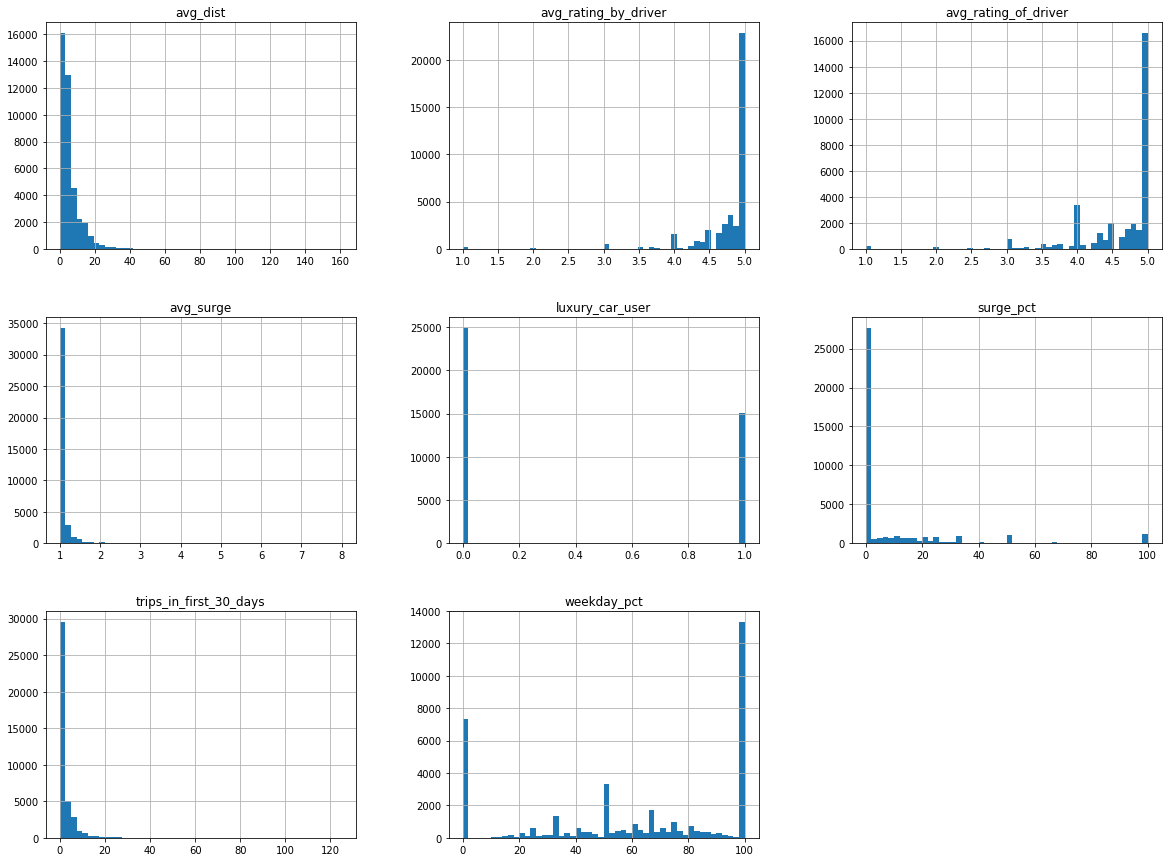

In [8]:
churn.hist(bins=50, figsize=(20,15));

## Adding Target Column

We define churn as not using the service within 30 days of when the data was collected. The data starts on January 1st 2014, and was collected on July 1st 2014. Therfore, we define a churned user as one who hasn't used the service since June 1st 2014.

- Data start time    --> January 1st 2014
- Data collected on  --> July 1st 2014
- Churn cut-off date --> June 1st 2014


In [9]:
end_date = pd.to_datetime('2014-07-01')
delta = pd.Timedelta('30 days')

In [10]:
churn['signup_date'] = pd.to_datetime(churn['signup_date'])
churn['last_trip_date'] = pd.to_datetime(churn['last_trip_date'])
churn['churn'] = ((end_date - churn['last_trip_date']) >= delta).astype(int)
churn.drop(['last_trip_date'], axis=1, inplace=True)

churn.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,churn
0,6.94,5.0,5.0,1.00,Astapor,Android,2014-01-12,0.0,0,False,100.0,1
1,8.06,5.0,5.0,1.00,Astapor,Android,2014-01-25,0.0,2,True,0.0,1
2,21.50,4.0,NaN,1.00,Winterfell,iPhone,2014-01-02,0.0,1,True,100.0,1
3,9.46,5.0,NaN,2.75,Winterfell,Android,2014-01-09,100.0,1,False,100.0,1
4,13.77,5.0,NaN,1.00,Winterfell,iPhone,2014-01-31,0.0,0,False,100.0,1


## Checking Class Balance

In [35]:
class_values = churn['churn'].value_counts()

negative_class_count = class_values[0]
positive_class_count = class_values[1]

print("Positive Class Count: {}, Negative Class Count: {}".format(positive_class_count, negative_class_count))
print("Churn Percentage: {0:.2f}%".format(positive_class_count/40000 * 100))
print("Not Churn Percentage: {0:.2f}%".format(negative_class_count/40000 * 100))

Positive Class Count: 25365, Negative Class Count: 14635
Churn Percentage: 63.41%
Not Churn Percentage: 36.59%


## Imputing Missing Values
Lets impute some values for the following features:
- 'avg_rating_by_driver'
- 'avg_rating_of_driver'

In [12]:
#impute 'avg_rating_by_driver' and 'avg_rating_of_driver' with median rating

rating_imputer = Imputer(strategy='median')
rating_imputer.fit(churn[['avg_rating_by_driver', 'avg_rating_of_driver']])

imputed_ratings = rating_imputer.transform(churn[['avg_rating_by_driver', 'avg_rating_of_driver']])
imputed_ratings = pd.DataFrame(imputed_ratings, columns=['avg_rating_by_driver', 'avg_rating_of_driver'])

churn[['avg_rating_by_driver', 'avg_rating_of_driver']] = imputed_ratings


#impute 'phone' with majority class
churn['phone'] = churn['phone'].fillna('iPhone')

## Dealing With Categoricals

In [13]:
churn_clean = pd.get_dummies(data=churn, columns=['phone', 'city'], drop_first=True)

## Converting/Dropping Column Types

In [14]:
churn_clean['luxury_car_user'] = churn_clean['luxury_car_user'].astype(int)
churn_clean.drop(['signup_date'], axis=1, inplace=True)

In [15]:
churn_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 12 columns):
avg_dist                  40000 non-null float64
avg_rating_by_driver      40000 non-null float64
avg_rating_of_driver      40000 non-null float64
avg_surge                 40000 non-null float64
surge_pct                 40000 non-null float64
trips_in_first_30_days    40000 non-null int64
luxury_car_user           40000 non-null int64
weekday_pct               40000 non-null float64
churn                     40000 non-null int64
phone_iPhone              40000 non-null uint8
city_King's Landing       40000 non-null uint8
city_Winterfell           40000 non-null uint8
dtypes: float64(6), int64(3), uint8(3)
memory usage: 2.9 MB


## Feature Engineering Exploration

### Lets take a look at the churn statistics based on 'trips_in_first_30_days'

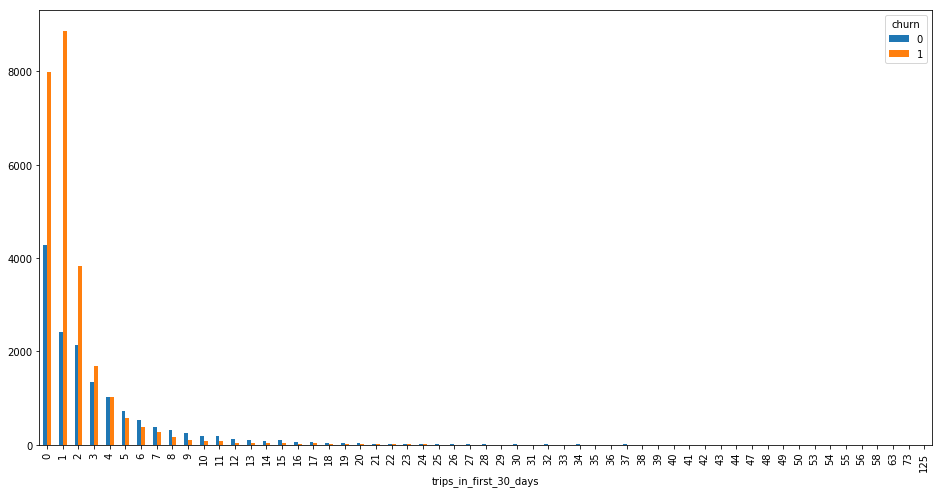

In [16]:
churn_clean.groupby('churn').trips_in_first_30_days.value_counts().unstack(0).plot.bar(figsize=(16, 8));

In [17]:
weak_user = (churn_clean['trips_in_first_30_days'] <= 2).astype(int)
churn_clean['weak_user'] = weak_user

power_user = (churn_clean['trips_in_first_30_days'] >= 5).astype(int)
churn_clean['power_user'] = power_user

### Now lets take a quick look at the avg distance traveled within the first 30 days of signup

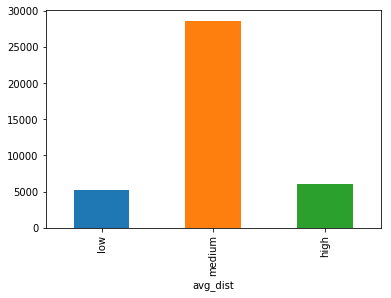

In [18]:
bins = [0,1.8,10,100]
labels = ['low', 'medium', 'high'] 
test = churn_clean.groupby(pd.cut(churn_clean['avg_dist'], bins=bins, labels=labels)).avg_dist.count()
test.plot(kind='bar');

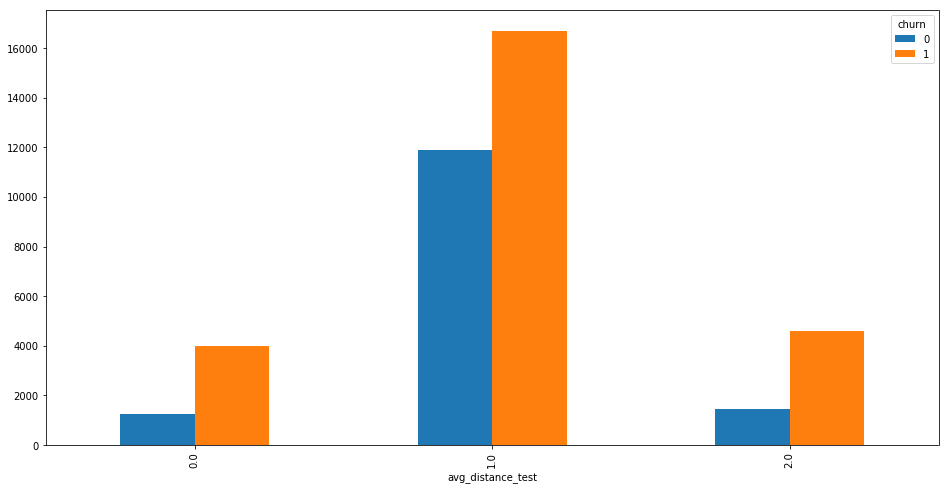

In [19]:
churn_clean['avg_distance_test'] = pd.cut(churn_clean['avg_dist'], bins=bins, labels=False)
churn_clean.groupby('churn').avg_distance_test.value_counts().unstack(0).plot.bar(figsize=(16, 8));

In [20]:
churn_final = churn_clean

churn_final['extreme_dist'] = (churn_clean['avg_distance_test'] != 1).astype(int)
churn_final = churn_final.drop(['avg_distance_test'], axis = 1)

## Lets Look At Ratings of Drivers

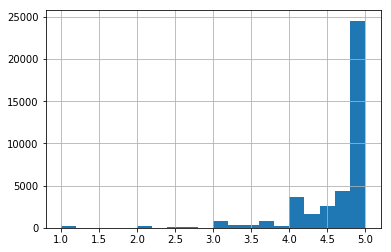

In [26]:
churn_final['avg_rating_of_driver'].hist(bins=20, log)

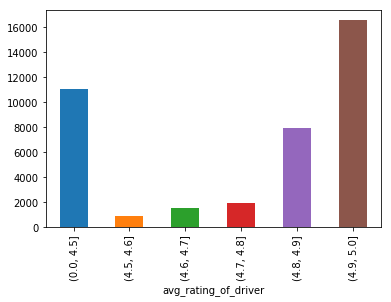

In [29]:
bins = [0,4.5, 4.6, 4.7, 4.8, 4.9, 5]
test = churn_final.groupby(pd.cut(churn_final['avg_rating_of_driver'], bins=bins)).avg_rating_of_driver.count()
test.plot(kind='bar');

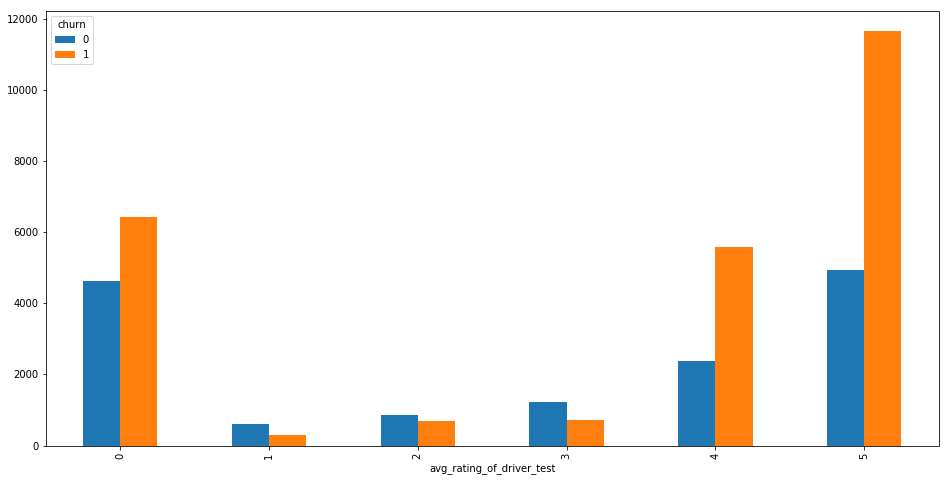

In [30]:
churn_final['avg_rating_of_driver_test'] = pd.cut(churn_final['avg_rating_of_driver'], bins=bins, labels=False)
churn_final.groupby('churn').avg_rating_of_driver_test.value_counts().unstack(0).plot.bar(figsize=(16, 8));

In [ ]:
log_rating = churn_final['avg_rating_of_driver_test'].lo

## Lets Look at Ratings By Drivers

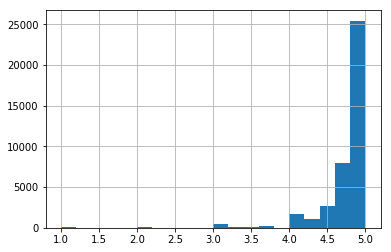

In [31]:
churn_final['avg_rating_by_driver'].hist(bins=20)

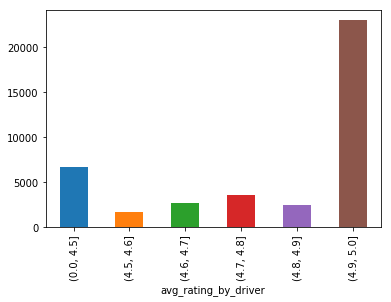

In [32]:
bins = [0,4.5, 4.6, 4.7, 4.8, 4.9, 5]
test = churn_final.groupby(pd.cut(churn_final['avg_rating_by_driver'], bins=bins)).avg_rating_by_driver.count()
test.plot(kind='bar');

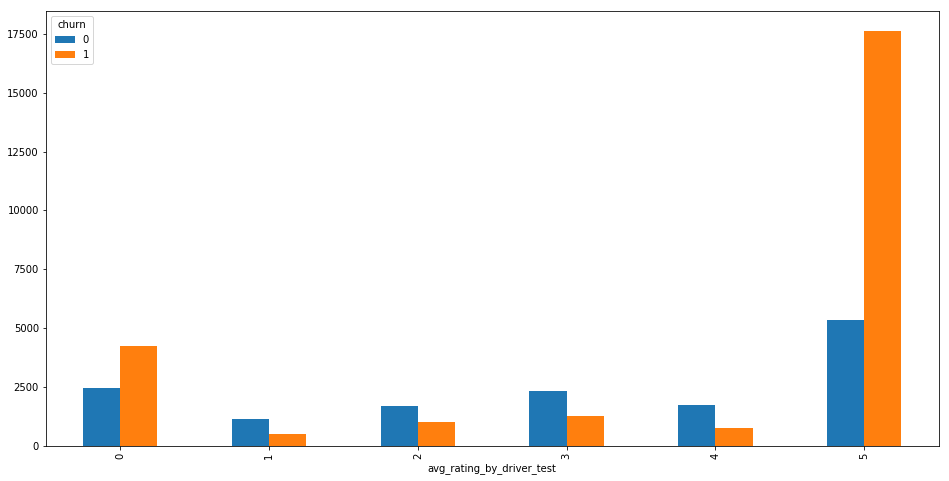

In [33]:
churn_final['avg_rating_by_driver_test'] = pd.cut(churn_final['avg_rating_by_driver'], bins=bins, labels=False)
churn_final.groupby('churn').avg_rating_by_driver_test.value_counts().unstack(0).plot.bar(figsize=(16, 8));

## Checking Linear Correlation 

In [23]:
corr_matrix = churn_final.corr()
corr_matrix['churn'].sort_values(ascending=False)

churn                     1.000000
weak_user                 0.232447
extreme_dist              0.164984
avg_dist                  0.090518
city_Winterfell           0.046989
avg_rating_of_driver      0.039903
avg_rating_by_driver      0.026790
avg_surge                 0.003577
surge_pct                -0.010020
weekday_pct              -0.024972
luxury_car_user          -0.211827
trips_in_first_30_days   -0.214718
power_user               -0.222680
phone_iPhone             -0.232897
city_King's Landing      -0.269171
Name: churn, dtype: float64

In [24]:
churn_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 15 columns):
avg_dist                  40000 non-null float64
avg_rating_by_driver      40000 non-null float64
avg_rating_of_driver      40000 non-null float64
avg_surge                 40000 non-null float64
surge_pct                 40000 non-null float64
trips_in_first_30_days    40000 non-null int64
luxury_car_user           40000 non-null int64
weekday_pct               40000 non-null float64
churn                     40000 non-null int64
phone_iPhone              40000 non-null uint8
city_King's Landing       40000 non-null uint8
city_Winterfell           40000 non-null uint8
weak_user                 40000 non-null int64
power_user                40000 non-null int64
extreme_dist              40000 non-null int64
dtypes: float64(6), int64(6), uint8(3)
memory usage: 3.8 MB
